# Unet Cell Segmentation

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

# Data Preperation

In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
width_out = 128
height_out = 128
TRAIN_PATH = './train/'
TEST_PATH = './test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get and resize train images and masks
x_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_ids), height_out, width_out, 1), dtype=np.bool)

# Get and resize train images
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_train[n] = img
    mask = np.zeros((height_out, width_out, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (height_out, width_out), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    y_train[n] = mask

# Get and resize test images
x_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\lashl\AppData\Local\Temp/ipykernel_13456/2597570701.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.zeros((len(train_ids), height_out, width_out, 1), dtype=np.bool)
  0%|                                                                                          | 0/670 [00:00<?, ?it/s]C:\Users\lashl\AppData\Local\Temp/ipykernel_13456/2597570701.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and gui

Getting and resizing test images ... 



100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 59.64it/s]

Done!


In [4]:
x_train.shape, y_train.shape, x_test.shape

((670, 128, 128, 3), (670, 128, 128, 1), (65, 128, 128, 3))

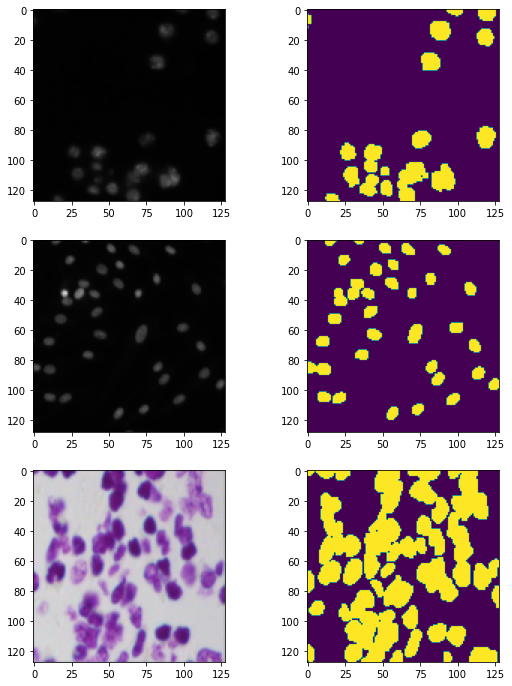

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9,12))
ax[0][0].imshow(x_train[0])
ax[0][1].imshow(np.squeeze(y_train[0]))
ax[1][0].imshow(x_train[1])
ax[1][1].imshow(np.squeeze(y_train[1]))
ax[2][0].imshow(x_train[2])
ax[2][1].imshow(np.squeeze(y_train[2]))

In [6]:
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=0.25)

In [7]:
x_train = x_train.transpose((0,3,1,2))
y_train = y_train.transpose((0,3,1,2))
x_val = x_val.transpose((0,3,1,2))
y_val = y_val.transpose((0,3,1,2))
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((502, 3, 128, 128),
 (502, 1, 128, 128),
 (168, 3, 128, 128),
 (168, 1, 128, 128))

In [8]:
#np.save('./x_train',x_train,allow_pickle =False)
#np.save('./x_val',x_val,allow_pickle =False)
#np.save('./y_train',y_train,allow_pickle =False)
#np.save('./y_val',y_train,allow_pickle =False)
x_train = np.load('./x_train.npy', mmap_mode='r')
x_val = np.load('./x_val.npy', mmap_mode='r')
y_train = np.load('./y_train.npy', mmap_mode='r')
y_val = np.load('./y_val.npy', mmap_mode='r')